# SSNE - Mini Projekt 5

Klasyfikacja sekwencji o różnych długościach.

Jan Jędrzejewski, Dominik Łopatecki

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pickle
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [3]:
def get_accuracy(net, data_loader):
    correct, total = 0, 0
    with torch.no_grad():
        for x, targets, x_len, target_len in data_loader:
            x = x.to(device).unsqueeze(2)
            targets = targets.to(device)
            hidden, state = net.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, last_hidden = net(x.float(), x_len, (hidden,state))
            _, preds = torch.max(preds, dim=1)
            for i in range(len(preds)):
                if preds[i].item() == targets[i].item():
                    correct += 1
            total += x.shape[0]
    return correct / total * 100

def conf_matrix(net, data_loader):
    out, lab = [], []
    with torch.no_grad():
        for x, targets, x_len, target_len in data_loader:
            x = x.to(device).unsqueeze(2)
            targets = targets.to(device)
            hidden, state = net.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, last_hidden = net(x.float(), x_len, (hidden,state))
            _, preds = torch.max(preds, dim=1)
            out += preds
            lab += targets
    lab, out = torch.tensor(lab).cpu(), torch.tensor(out).cpu()
    return confusion_matrix(lab, out)


# Dane

In [4]:
!unzip p5.zip

Archive:  p5.zip
  inflating: p4/test_no_target.pkl   
  inflating: p4/train.pkl            
  inflating: p4/tresc_zadania.txt    


In [4]:
with open('p4/train.pkl', 'rb') as f:
    all_data = pickle.load(f)

In [5]:
max_seq = 0

for seq, _ in all_data:
  max_seq = max(max_seq, len(seq))

MAX_SEQ = max_seq
MAX_SEQ

6308

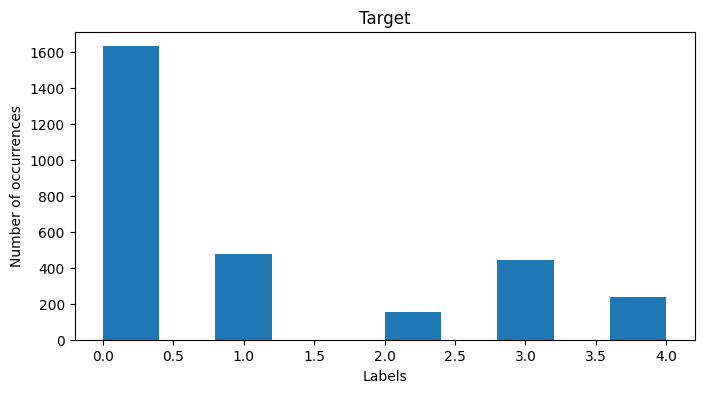

class 0 (bach): 0.5546104117046614
class 1 (bethoven): 0.16264035386185777
class 2 (debussy): 0.052398775093569244
class 3 (scarlatti): 0.1500510377679483
class 4 (victoria): 0.08029942157196325


In [112]:
targets = [torch.tensor(x[1]) for x in all_data]
plt.figure(figsize=(8,4))
plt.hist(targets)
plt.title("Target")
plt.xlabel("Labels")
plt.ylabel("Number of occurrences")
plt.show()

print(f"class 0 (bach): {targets.count(0)/len(targets)}")
print(f"class 1 (bethoven): {targets.count(1)/len(targets)}")
print(f"class 2 (debussy): {targets.count(2)/len(targets)}")
print(f"class 3 (scarlatti): {targets.count(3)/len(targets)}")
print(f"class 4 (victoria): {targets.count(4)/len(targets)}")

## Dataset

In [6]:
class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]      

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

In [7]:
generator = torch.Generator().manual_seed(42)
train_set_init, test_set_init = random_split(all_data, [0.8, 0.2], generator=generator)
train_set = VariableLenDataset([torch.tensor(x[0]) for x in train_set_init], [torch.tensor([x[1]]) for x in train_set_init])
test_set = VariableLenDataset([torch.tensor(x[0]) for x in test_set_init], [torch.tensor([x[1]]) for x in test_set_init])

## Dataloader

In [8]:
def pad_collate(batch, pad_value=0):
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [1 for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=pad_value)

    return xx_pad, yy_pad, x_lens, y_lens

In [9]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, collate_fn=pad_collate)

# Model sieci

In [11]:
class LSTMClassifier(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, dropout, bidirectional = False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_size*MAX_SEQ*self.bidirectional, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, x_len, hidden):
        x = torch.transpose(x,0,1)
        x = pack_padded_sequence(x, x_len,enforce_sorted=False)  # usuniecie padingu aby stany ukryte bylu uczone tylko na prawdziwych danych
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs, _ = pad_packed_sequence(all_outputs, padding_value=0, total_length=MAX_SEQ)
        all_outputs = torch.transpose(all_outputs,0,1)
        out = torch.flatten(all_outputs,1)
        x = self.fc(out)
        return x, hidden

# Trening

## 1) Bazowy model

In [ ]:
model = LSTMClassifier(1, 200, 4, 5, dropout=0.6, bidirectional=True).to(device)
model

LSTMClassifier(
  (lstm): LSTM(1, 200, num_layers=4, dropout=0.6, bidirectional=True)
  (fc): Linear(in_features=2523200, out_features=5, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.CrossEntropyLoss()

iters, losses, trains_acc, tests_acc = [], [], [], []
for epoch in range(51):
    model.train()
    for x, targets, x_len, target_len in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, last_hidden = model(x.float(), x_len, (hidden,state))
        optimizer.zero_grad()
        loss = loss_fun(preds, torch.tensor([x[0] for x in targets]).to(device))
        loss.backward()
        optimizer.step()
    train_acc = get_accuracy(model, train_loader)
    test_acc = get_accuracy(model, test_loader)
    iters.append(epoch)
    losses.append(loss.item())
    trains_acc.append(train_acc)
    tests_acc.append(test_acc)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {round(loss.item(), 6)} train_acc: {train_acc:.4}% test_acc: {test_acc:.4}%")

Epoch: 0, loss: 1.200236 train_acc: 58.08% test_acc: 56.56%
Epoch: 10, loss: 0.204216 train_acc: 96.22% test_acc: 65.93%
Epoch: 20, loss: 0.015345 train_acc: 99.45% test_acc: 65.76%
Epoch: 30, loss: 0.00121 train_acc: 100.0% test_acc: 66.78%
Epoch: 40, loss: 0.001365 train_acc: 100.0% test_acc: 66.27%
Epoch: 50, loss: 0.000122 train_acc: 100.0% test_acc: 67.8%


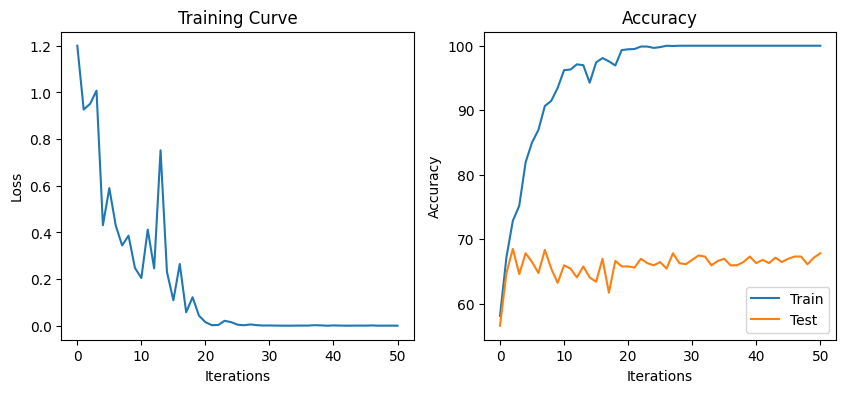

Training set accuracy: 100.0%
Test set accuracy: 67.97%


In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(iters, trains_acc, label="Train")
plt.plot(iters, tests_acc, label="Test")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

print(f"Training set accuracy: {get_accuracy(model, train_loader):.4}%")
print(f"Test set accuracy: {get_accuracy(model, test_loader):.4}%")

Podstawowy model osiągnął skuteczność 100% na zbiorze treningowym już po 20 iteracjach. Na zbiorze testowym skuteczność zatrzymałą się na stałym poziomie około 66%. Mamy doczynienie z typowym przykładem przeuczenia, model za bardzo dopasowuje się do danych treningowych. Można zwiększyć liczbę wag, lub zastosować techniki zapobiegające przeuczeniu.

## 2) Więcej warstw, większy rozmiar

In [14]:
model2 = LSTMClassifier(1, 300, 6, 5, dropout=0.8, bidirectional=True).to(device)
model2

LSTMClassifier(
  (lstm): LSTM(1, 300, num_layers=6, dropout=0.8, bidirectional=True)
  (fc): Linear(in_features=3784800, out_features=5, bias=True)
)

Googel collab nie wytrzymuje więcej wag. Kończy się miejsce w pamięci RAM. Zostaniemy przy poprzednim rozmiarze warstwy ukrytej oraz przy poprzeniej liczbie warstw. Dodamy dropout i weight decay aby zapobiegać przeyczeniu.

## 3) Krótrze uczenie i większy drop i weight decay

In [20]:
model3 = LSTMClassifier(1, 200, 4, 5, dropout=0.8, bidirectional=True).to(device)
model3

LSTMClassifier(
  (lstm): LSTM(1, 200, num_layers=4, dropout=0.8, bidirectional=True)
  (fc): Linear(in_features=2523200, out_features=5, bias=True)
)

In [21]:
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001, weight_decay=0.01)
loss_fun = nn.CrossEntropyLoss()

iters, losses, trains_acc, tests_acc = [], [], [], []
for epoch in range(31):
    model3.train()
    for x, targets, x_len, target_len in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model3.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, last_hidden = model3(x.float(), x_len, (hidden,state))
        optimizer.zero_grad()
        loss = loss_fun(preds, torch.tensor([x[0] for x in targets]).to(device))
        loss.backward()
        optimizer.step()
    train_acc = get_accuracy(model3, train_loader)
    test_acc = get_accuracy(model3, test_loader)
    iters.append(epoch)
    losses.append(loss.item())
    trains_acc.append(train_acc)
    tests_acc.append(test_acc)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {round(loss.item(), 6)} train_acc: {train_acc:.4}% test_acc: {test_acc:.4}%")

Epoch: 0, loss: 1.066538 train_acc: 60.97% test_acc: 60.48%
Epoch: 10, loss: 0.980562 train_acc: 72.92% test_acc: 74.11%
Epoch: 20, loss: 0.710234 train_acc: 75.74% test_acc: 79.56%
Epoch: 30, loss: 0.651753 train_acc: 77.78% test_acc: 80.41%


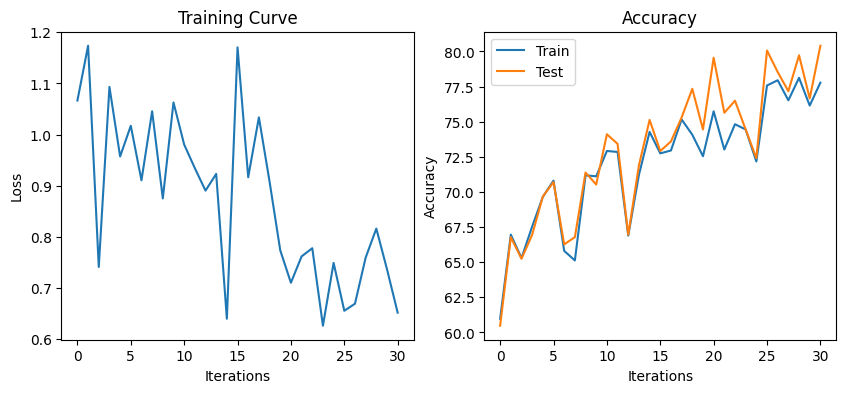

Training set accuracy: 77.51%
Test set accuracy: 79.39%


In [22]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(iters, trains_acc, label="Train")
plt.plot(iters, tests_acc, label="Test")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

print(f"Training set accuracy: {get_accuracy(model3, train_loader):.4}%")
print(f"Test set accuracy: {get_accuracy(model3, test_loader):.4}%")

Model tym razem się nie przeuczył, osiągnął naprawdę zadowalające wyniki. Skuteczność predykcji na poziomie niecałych 80% zarówno dla zbiory trenującego jak i testowego. Przyjżyjmy się jak wygląda skuteczność predykcji względem klas.

Text(0.5, 1.0, 'Model3 - test set')

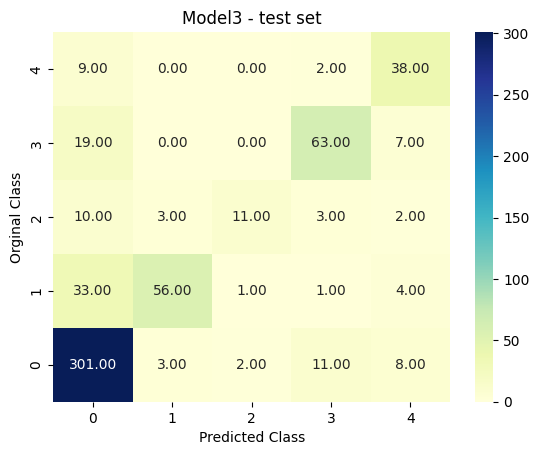

In [23]:
sns.heatmap(
        np.flip(conf_matrix(model3, test_loader), 0),
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        xticklabels=[0, 1, 2, 3, 4],
        yticklabels=[4, 3, 2, 1, 0],
    )
plt.xlabel("Predicted Class")
plt.ylabel("Orginal Class")
plt.title("Model3 - test set")

Obserwujemy dysproporcje pomiędzy klasami. Klasy mniej liczne są narażone na nieuwzględnienie w procesie uczenia, ponieważ bardziej prawdopoobne jest wystąpienie klasy liczniejszej. Spróbujemy dodać wagi dla klas mniej licznych aby były równie istotne podczas uczenia.

## 4) Ważenie klas

Klasa, występowanie, waga
- 0:   0.55  -  1
- 1:   0.16  -  3.5
- 2:   0.05  -  11
- 3:   0.15  -  3.5
- 4:   0.08  -  7

In [12]:
model4 = LSTMClassifier(1, 200, 4, 5, dropout=0.8, bidirectional=True).to(device)
model4

LSTMClassifier(
  (lstm): LSTM(1, 200, num_layers=4, dropout=0.8, bidirectional=True)
  (fc): Linear(in_features=2523200, out_features=5, bias=True)
)

In [14]:
optimizer = torch.optim.Adam(model4.parameters(), lr=0.001, weight_decay=0.01)
loss_fun = nn.CrossEntropyLoss(weight=torch.Tensor([1, 3.5, 11, 3.5, 7]).to(device))

iters, losses, trains_acc, tests_acc = [], [], [], []
for epoch in range(51):
    model4.train()
    for x, targets, x_len, target_len in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model4.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, last_hidden = model4(x.float(), x_len, (hidden,state))
        optimizer.zero_grad()
        loss = loss_fun(preds, torch.tensor([x[0] for x in targets]).to(device))
        loss.backward()
        optimizer.step()
    train_acc = get_accuracy(model4, train_loader)
    test_acc = get_accuracy(model4, test_loader)
    iters.append(epoch)
    losses.append(loss.item())
    trains_acc.append(train_acc)
    tests_acc.append(test_acc)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {round(loss.item(), 6)} train_acc: {train_acc:.4}% test_acc: {test_acc:.4}%")

Epoch: 0, loss: 1.559185 train_acc: 45.96% test_acc: 46.85%
Epoch: 10, loss: 0.880853 train_acc: 67.47% test_acc: 55.71%
Epoch: 20, loss: 0.622367 train_acc: 76.15% test_acc: 55.03%
Epoch: 30, loss: 0.607088 train_acc: 85.67% test_acc: 60.14%
Epoch: 40, loss: 0.406021 train_acc: 84.78% test_acc: 58.94%
Epoch: 50, loss: 0.496251 train_acc: 88.99% test_acc: 61.16%


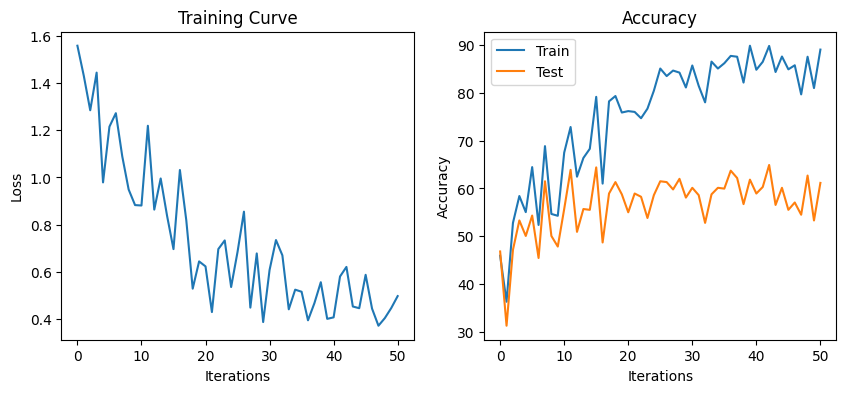

Training set accuracy: 88.9%
Test set accuracy: 61.5%


In [15]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(iters, trains_acc, label="Train")
plt.plot(iters, tests_acc, label="Test")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

print(f"Training set accuracy: {get_accuracy(model4, train_loader):.4}%")
print(f"Test set accuracy: {get_accuracy(model4, test_loader):.4}%")

Text(0.5, 1.0, 'Model4 - test set')

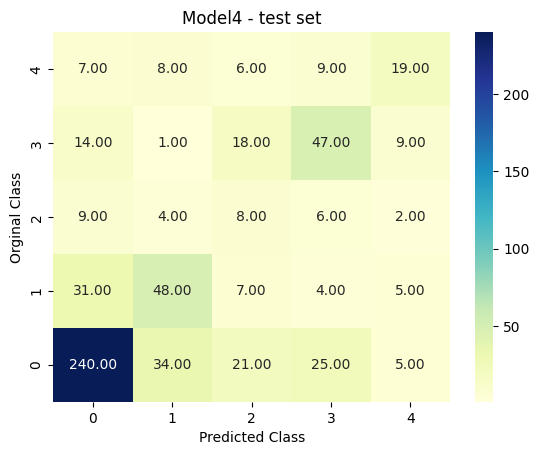

In [16]:
sns.heatmap(
        np.flip(conf_matrix(model4, test_loader), 0),
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        xticklabels=[0, 1, 2, 3, 4],
        yticklabels=[4, 3, 2, 1, 0],
    )
plt.xlabel("Predicted Class")
plt.ylabel("Orginal Class")
plt.title("Model4 - test set")

Pomimo dodania wyższych wag klasom które rzadziej występują w zbiorze danych, nie widać poprawy skuteczności predykcji. W macierzy pomyłek znowu najwięcejpoprawnych predykcji jest dla klas 0, 1, 3 a dla najrzadszych klas 2 i 4 praktycznie losowo przypoisywane są klasy. Co więcej pogorszyły się predykcje dla liczbniejszych klas.

## 5) Finalny model

Jako końcowy model wybieramy najbardziej dla nas skuteczny model numer 3. Trenujemy go na całym zbiorze treningowym.

In [24]:
train_set = VariableLenDataset([torch.tensor(x[0]) for x in all_data], [torch.tensor([x[1]]) for x in all_data])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=pad_collate)

In [25]:
model5 = LSTMClassifier(1, 200, 4, 5, dropout=0.8, bidirectional=True).to(device)
model5

LSTMClassifier(
  (lstm): LSTM(1, 200, num_layers=4, dropout=0.8, bidirectional=True)
  (fc): Linear(in_features=2523200, out_features=5, bias=True)
)

In [27]:
optimizer = torch.optim.Adam(model5.parameters(), lr=0.001, weight_decay=0.01)
loss_fun = nn.CrossEntropyLoss()

iters, losses, trains_acc = [], [], []
for epoch in range(31):
    model5.train()
    for x, targets, x_len, target_len in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model5.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, last_hidden = model5(x.float(), x_len, (hidden,state))
        optimizer.zero_grad()
        loss = loss_fun(preds, torch.tensor([x[0] for x in targets]).to(device))
        loss.backward()
        optimizer.step()
    train_acc = get_accuracy(model5, train_loader)
    iters.append(epoch)
    losses.append(loss.item())
    trains_acc.append(train_acc)
    if epoch % 5 == 0:
        print(f"Epoch: {epoch}, loss: {round(loss.item(), 6)} train_acc: {train_acc:.4}%")

Epoch: 0, loss: 0.98689 train_acc: 64.17%
Epoch: 5, loss: 1.079184 train_acc: 67.27%
Epoch: 10, loss: 0.930806 train_acc: 72.13%
Epoch: 15, loss: 0.933795 train_acc: 72.0%
Epoch: 20, loss: 0.978152 train_acc: 75.71%
Epoch: 25, loss: 0.925838 train_acc: 77.68%
Epoch: 30, loss: 0.602646 train_acc: 77.78%


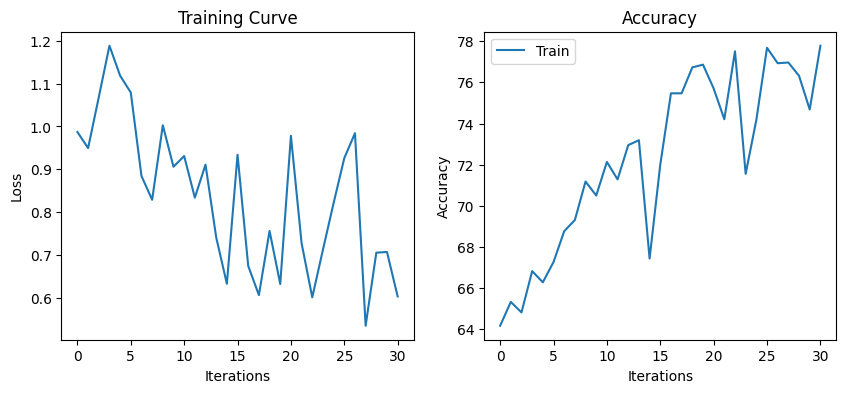

Training set accuracy: 78.02%


In [28]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(iters, trains_acc, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

print(f"Training set accuracy: {get_accuracy(model5, train_loader):.4}%")

Text(0.5, 1.0, 'Model5 - train set')

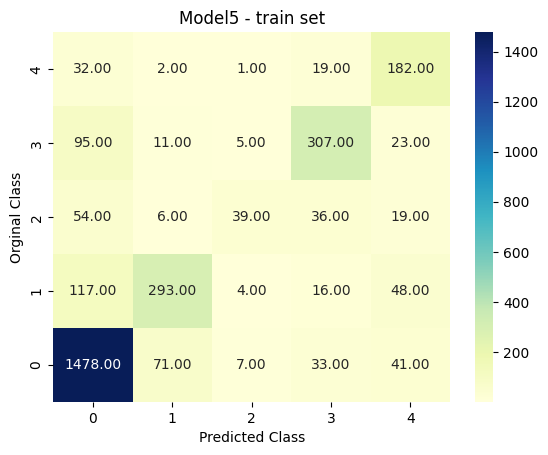

In [29]:
sns.heatmap(
        np.flip(conf_matrix(model5, train_loader), 0),
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        xticklabels=[0, 1, 2, 3, 4],
        yticklabels=[4, 3, 2, 1, 0],
    )
plt.xlabel("Predicted Class")
plt.ylabel("Orginal Class")
plt.title("Model5 - train set")

# Generowanie predykcji

Za pomocą finalnego modelu numer 5 generujemy predykcje dla zadanego zbioru sekwencji

In [103]:
with open('p4/test_no_target.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [104]:
test_var_set = VariableLenDataset([torch.tensor(x) if len(x) < 6308 else torch.tensor(x[:6308]) for x in test_data], [torch.tensor([0]) for x in test_data])
test_no_target_loader = DataLoader(test_var_set, batch_size=1, shuffle=False, drop_last=False, collate_fn=pad_collate)

In [105]:
PREDS = []
with torch.no_grad():
    for x, targets, x_len, target_len in test_no_target_loader:
            x = x.to(device).unsqueeze(2)
            hidden, state = model5.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, last_hidden = model5(x.float(), x_len, (hidden,state))
            _, preds = torch.max(preds, dim=1)
            PREDS += preds

In [106]:
len(test_data)

1103

In [109]:
df = pd.DataFrame(torch.tensor(PREDS).cpu())
df.head()

,0
0,4
1,0
2,0
3,0
4,0


In [110]:
df.to_csv("piatek_Jedrzejewski_Lopatecki.csv", index=False, header=None)

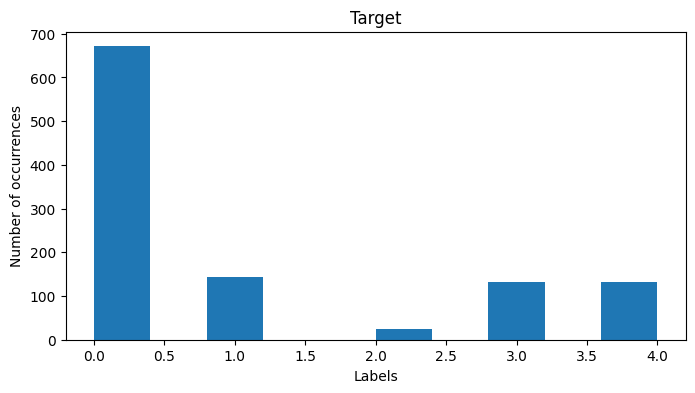

In [111]:
targets = torch.tensor(PREDS).cpu()
plt.figure(figsize=(8,4))
plt.hist(targets)
plt.title("Target")
plt.xlabel("Labels")
plt.ylabel("Number of occurrences")
plt.show()